<a href="https://colab.research.google.com/github/parshant393/INTERNSHIPS/blob/main/Automated_Electric_Meter_Reading_OCR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### METER READING OCR FINAL REPORT



It is a mask RCNN based meter reading model, that inputs an image with a meter screen. The screen is then detected and masked using the shared model. After the mask contours are found the image is rotated by the needed angle to allign the image parallel to the plane. Further, it is processed and scanned using open source OCR - EasyOCR.

[Model Link](https://drive.google.com/file/d/159-2hNkyrqdf-hTKj--AscRpUGBJag4v/view?usp=sharing)

## Installing

In [ ]:
!pip install ipyplot
!pip install imutils
!pip install pytesseract
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!wget https://pysource.com/extra_files/Mask_RCNN_basic_1.zip
!unzip Mask_RCNN_basic_1.zip
import sys
sys.path.append("/content/Mask_RCNN/mrcnn")
from m_rcnn import *
from visualize import random_colors, get_mask_contours, draw_mask
%matplotlib inline
!pip install torch torchvision torchaudio
!pip install easyocr

## Importing

In [ ]:
import cv2
import numpy as np 
import imutils
from imutils import perspective
import pytesseract
import easyocr
import matplotlib.pyplot as plt
from PIL import Image

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Preprocessing Image

Enter image path.

In [ ]:
im1 = cv2.imread("Image Path")
gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
th4 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

## Processing through model

In [ ]:
# Load Image
img = th4

test_model, inference_config = load_inference_model(1, "Model Path")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect results
r = test_model.detect([image])[0]
colors = random_colors(25)

## Coloring detected Data

In [ ]:
from google.colab.patches import cv2_imshow
# Get Coordinates and show it on the image
img2=img
object_count = len(r["class_ids"])
for i in range(object_count):
    # 1. Mask
    mask = r["masks"][:, :, i]
    contours = get_mask_contours(mask)
    for cnt in contours:
        #cv2.polylines(img, [cnt], True, 10, 2)
        img = draw_mask(img, [cnt], colors[i])

## Preparing mask for bg clearing

In [ ]:
hh, ww = img.shape[:2]
mask2 = np.zeros((hh,ww), dtype=np.uint8)
big_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(mask2, [big_contour], 0, (255,255,255), cv2.FILLED)

## Removing Unwanted Image

In [ ]:
mask_inv = 255 - mask2
bckgnd = np.full_like(img, (255,255,255))
image_masked = cv2.bitwise_and(img, img, mask=mask2)
bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask_inv)
result = cv2.add(image_masked, bckgnd_masked)
cv2_imshow(result)

## Getting corner points

In [ ]:
contour = contours[0]
box = cv2.minAreaRect(contour)
box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
box = np.array(box, dtype="float")
box = perspective.order_points(box)

## Rotating Image to adjust reading to plane level

In [ ]:
x1,x2,x3,x4,y1,y2,y3,y4 = box[0][0],box[1][0],box[2][0],box[3][0],box[0][1],box[1][1],box[2][1],box[3][1]
box1 = (x1,y1)
slope =  (y2-y1)/(x2-x1)
slope_angle = math.atan(slope)
degrees = math.degrees(slope_angle)
degrees
rot_mat = cv2.getRotationMatrix2D(box1, degrees, 1.0)
result1 = cv2.warpAffine(result, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
im = Image.fromarray(result1)
im.save("im.jpeg")
ocr_ready_img = cv2.imread("im.jpeg")
cv2_imshow(ocr_ready_img)

## Readjusting Image to make it readable with normal OCR

*It is recomended to use good quality images for this ocr else you need a more accurate 7 segment display ocr

In [ ]:
im2=cv2.cvtColor(ocr_ready_img, cv2.COLOR_BGR2GRAY)
im3 = cv2.threshold(im2,100,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
im4 = cv2.medianBlur(im3,3)
im5 = cv2.adaptiveThreshold(im4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
cv2_imshow(im4)
cv2_imshow(im5)

inverted = np.invert(im5)
kernal = cv2.getStructuringElement(cv2.MORPH_RECT,(1,7))
dilate = cv2.dilate(inverted,kernal,iterations=1)
cv2_imshow(dilate)

## Getting reading through Easy OCR

In [ ]:
reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext(final)
result

## Sample Results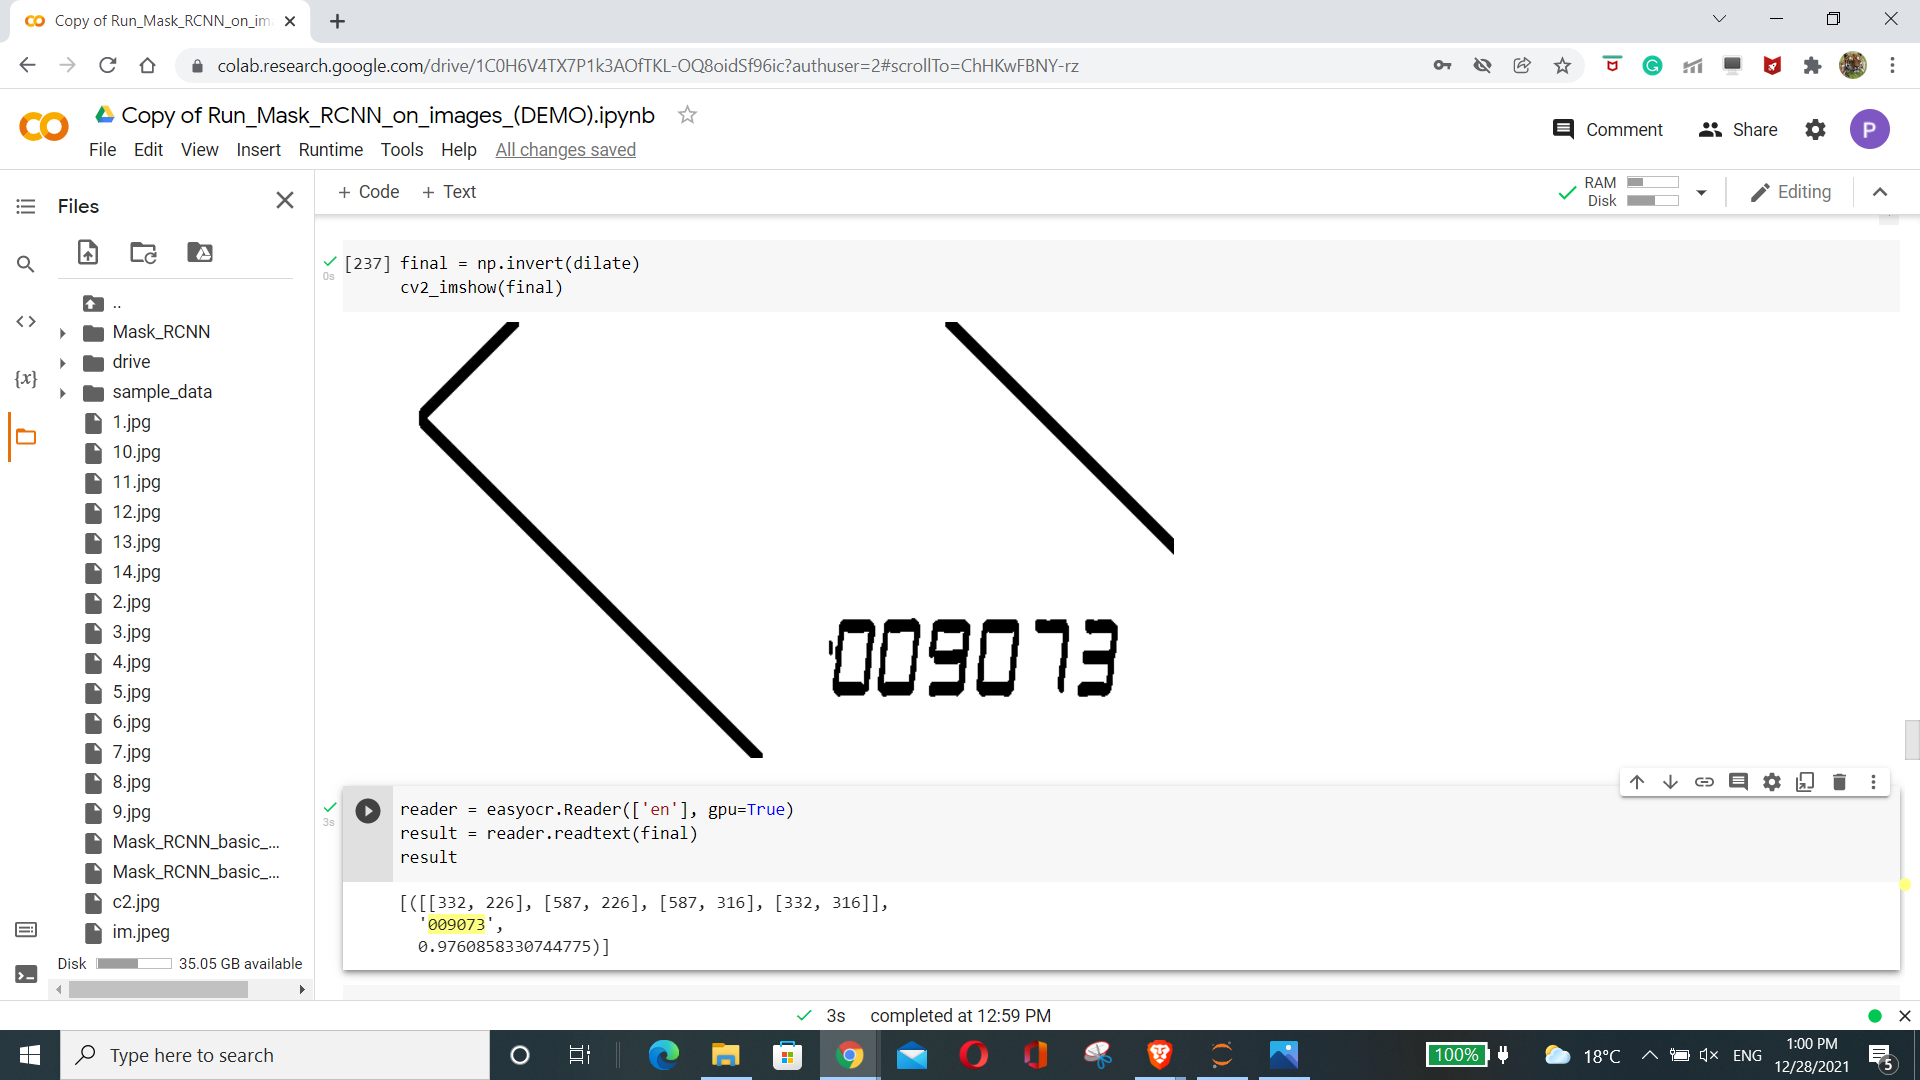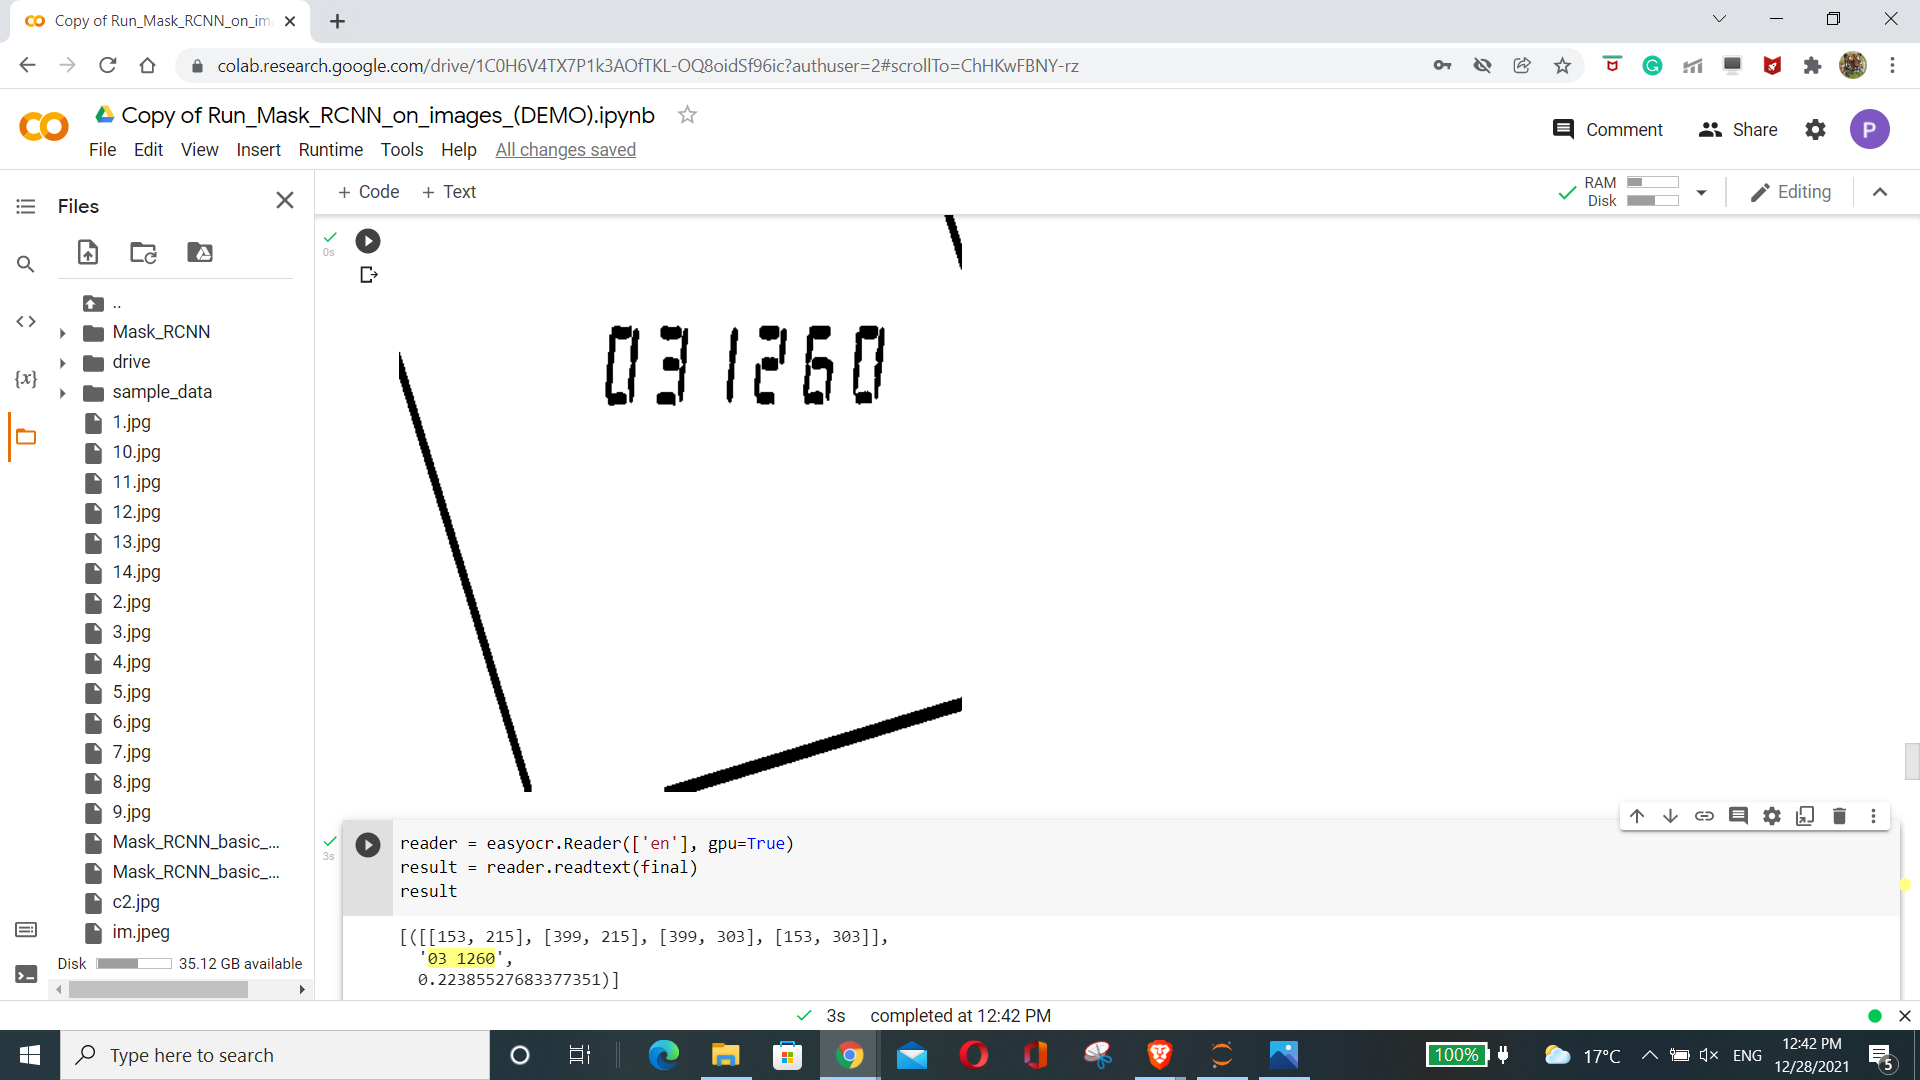

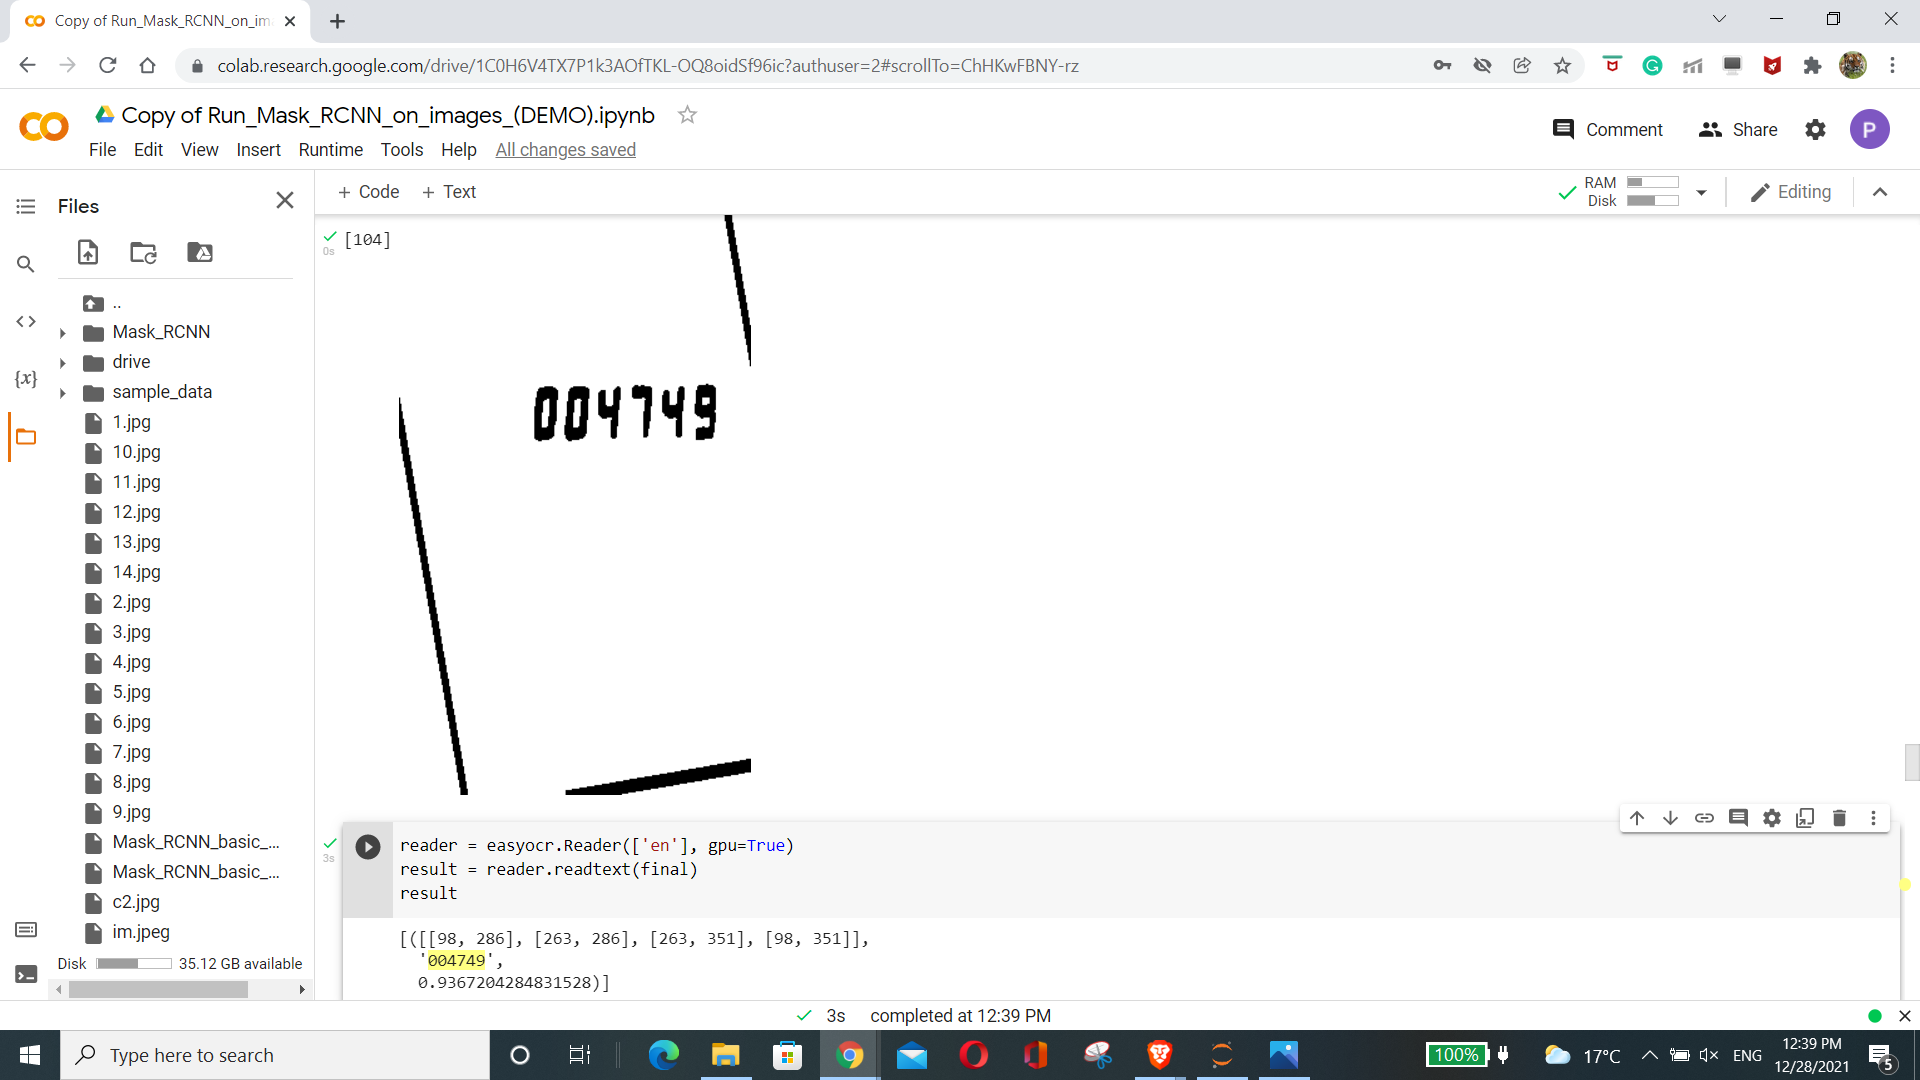

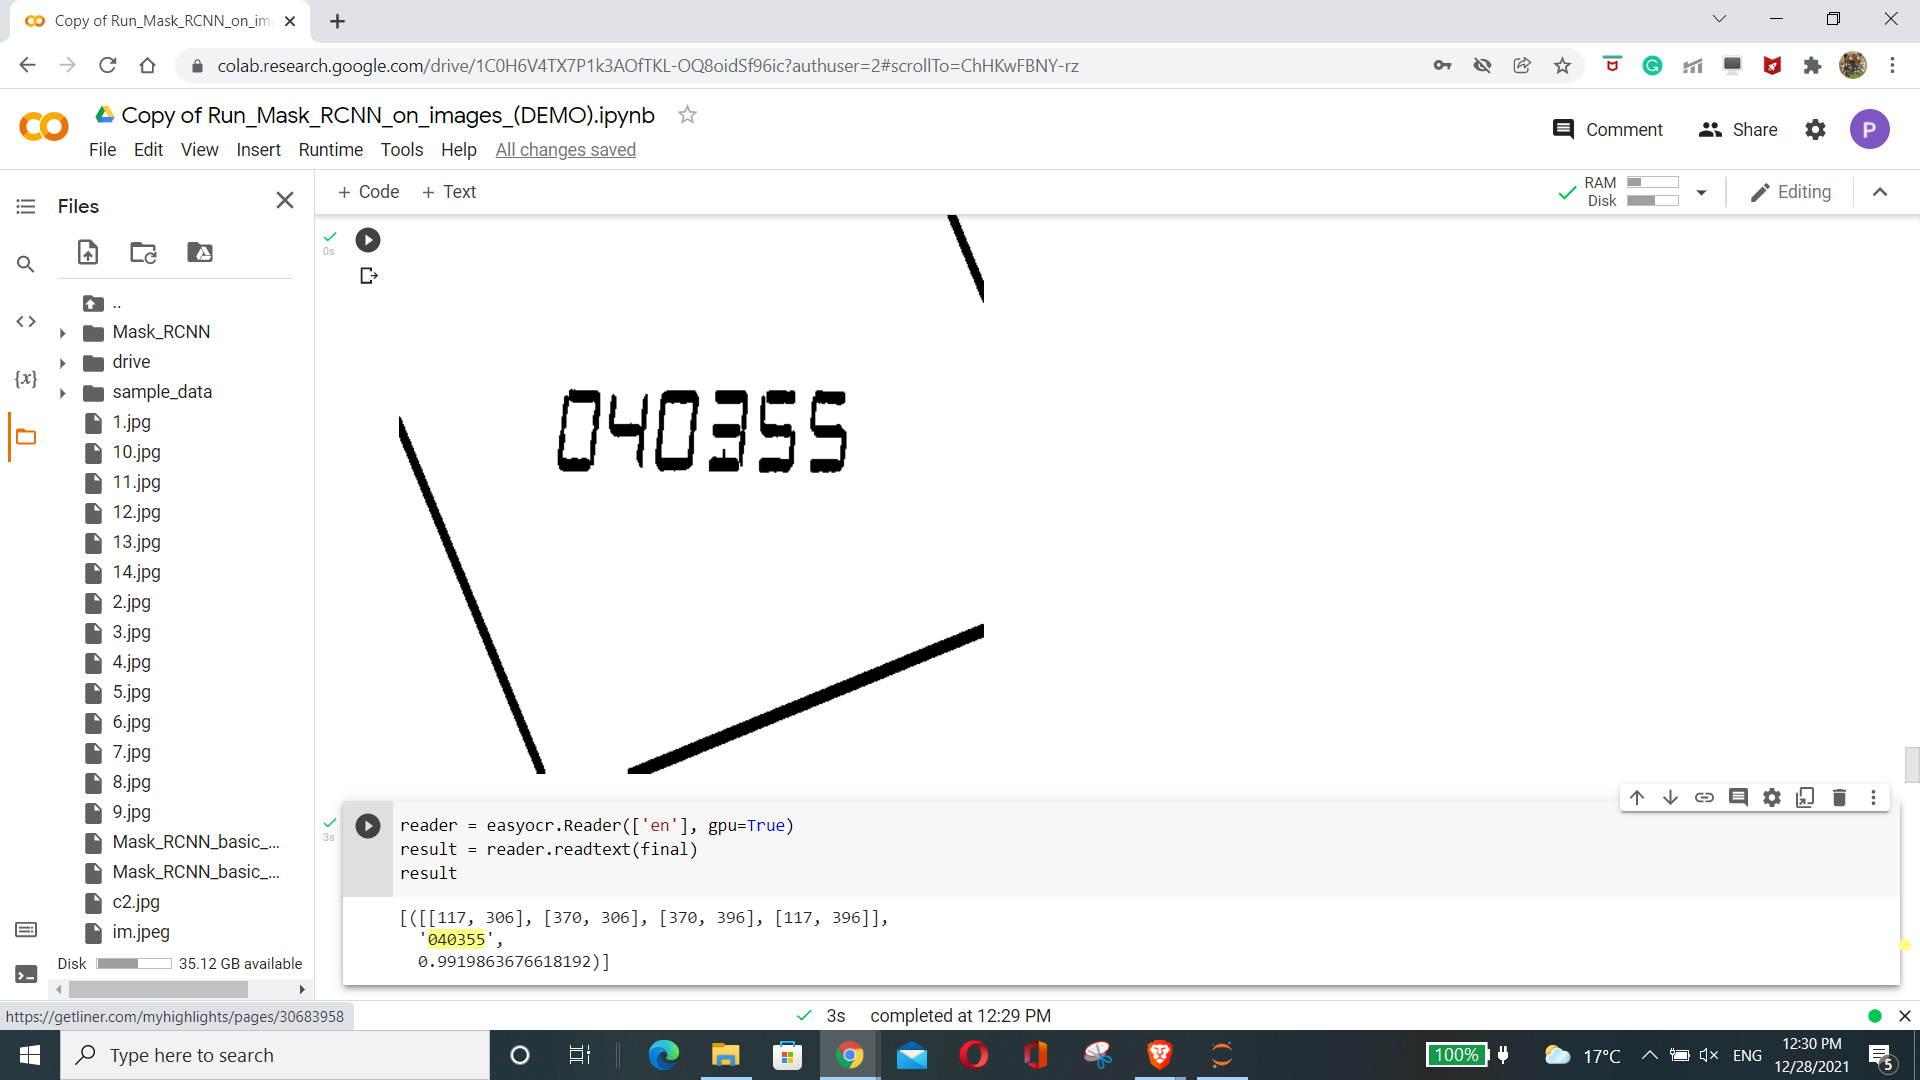